# **Network Analysis of MCU**

In [72]:
# !pip install python-louvain
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from community import community_louvain

# ------------------------------------------------------------------------------
# Step 1: Load the datasets
# ------------------------------------------------------------------------------
%cd /content/drive/Shared drives/ORF387 MCM Group Project/
nodes = pd.read_csv('nodes.csv')
edges = pd.read_csv('edges.csv')
hero_network = pd.read_csv('hero-network.csv')

/content/drive/Shared drives/ORF387 MCM Group Project


In [73]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [74]:
# ------------------------------------------------------------------------------
# Step 2: Analyze connections between heroes and comics
# ------------------------------------------------------------------------------

# How many times each hero appears in each comic
hero_comic_connections = edges.groupby(['hero', 'comic']).size()

# Find comics with most hero appearances (Determine Major events perhaps)
comic_popularity = edges['comic'].value_counts()

# Identify key heroes by their appearances in different comics
hero_uniqueness = edges.groupby('hero')['comic'].nunique()

# Display the top comics by the number of appearances and the top heroes by unique comic appearances
print("Top Comics by Number of Hero Appearances:")
print(comic_popularity.head(10), "\n")
print("Top Heroes by Unique Comic Appearances:")
print(hero_uniqueness.nlargest(10), "\n")

Top Comics by Number of Hero Appearances:
comic
COC 1       111
IW 3         91
IW 1         90
H2 279       87
IW 4         80
IW 2         76
MAXSEC 3     72
FF 370       62
IW 6         60
M/GN 1       60
Name: count, dtype: int64 

Top Heroes by Unique Comic Appearances:
hero
SPIDER-MAN/PETER PARKER    1577
CAPTAIN AMERICA            1334
IRON MAN/TONY STARK        1150
THING/BENJAMIN J. GR        963
THOR/DR. DONALD BLAK        956
HUMAN TORCH/JOHNNY S        886
MR. FANTASTIC/REED R        854
HULK/DR. ROBERT BRUC        835
WOLVERINE/LOGAN             819
INVISIBLE WOMAN/SUE         762
Name: comic, dtype: int64 



In [75]:
# ------------------------------------------------------------------------------
# Step 3: Determine the popularity of characters based on appearances and connections
# ------------------------------------------------------------------------------

# Count the number of appearances of each character in comics
character_appearances = edges['hero'].value_counts()

# Count connections in both 'hero1' and 'hero2' columns from the data
hero1_connections = hero_network['hero1'].value_counts()
hero2_connections = hero_network['hero2'].value_counts()
hero_connections = hero1_connections.add(hero2_connections, fill_value=0)

# Combine the counts of appearances and connections to determine popularity
popularity_scores = character_appearances.add(hero_connections, fill_value=0)

# Print top 10 most popular characters based on combined score
print("Top 10 Most Popular Characters Based on Appearances and Connections:")
print(popularity_scores.nlargest(10), "\n")

Top 10 Most Popular Characters Based on Appearances and Connections:
CAPTAIN AMERICA         17833.0
SPIDER-MAN/PETER PAR    13717.0
THOR/DR. DONALD BLAK    12383.0
IRON MAN/TONY STARK     11817.0
THING/BENJAMIN J. GR    11644.0
HUMAN TORCH/JOHNNY S    11123.0
MR. FANTASTIC/REED R    10629.0
WOLVERINE/LOGAN         10353.0
BEAST/HENRY &HANK& P     9922.0
SCARLET WITCH/WANDA      9911.0
Name: count, dtype: float64 



Top 25 Most Popular Characters:
CAPTAIN AMERICA         17833.0
SPIDER-MAN/PETER PAR    13717.0
THOR/DR. DONALD BLAK    12383.0
IRON MAN/TONY STARK     11817.0
THING/BENJAMIN J. GR    11644.0
HUMAN TORCH/JOHNNY S    11123.0
MR. FANTASTIC/REED R    10629.0
WOLVERINE/LOGAN         10353.0
BEAST/HENRY &HANK& P     9922.0
SCARLET WITCH/WANDA      9911.0
VISION                   9696.0
CYCLOPS/SCOTT SUMMER     9684.0
INVISIBLE WOMAN/SUE      9326.0
STORM/ORORO MUNROE S     9318.0
HAWK                     9088.0
WASP/JANET VAN DYNE      8426.0
HULK/DR. ROBERT BRUC     8350.0
COLOSSUS II/PETER RA     8315.0
ANT-MAN/DR. HENRY J.     7904.0
PROFESSOR X/CHARLES      7840.0
MARVEL GIRL/JEAN GRE     7413.0
ANGEL/WARREN KENNETH     7368.0
WONDER MAN/SIMON WIL     7066.0
NIGHTCRAWLER/KURT WA     6633.0
SHE-HULK/JENNIFER WA     6589.0
Name: count, dtype: float64 



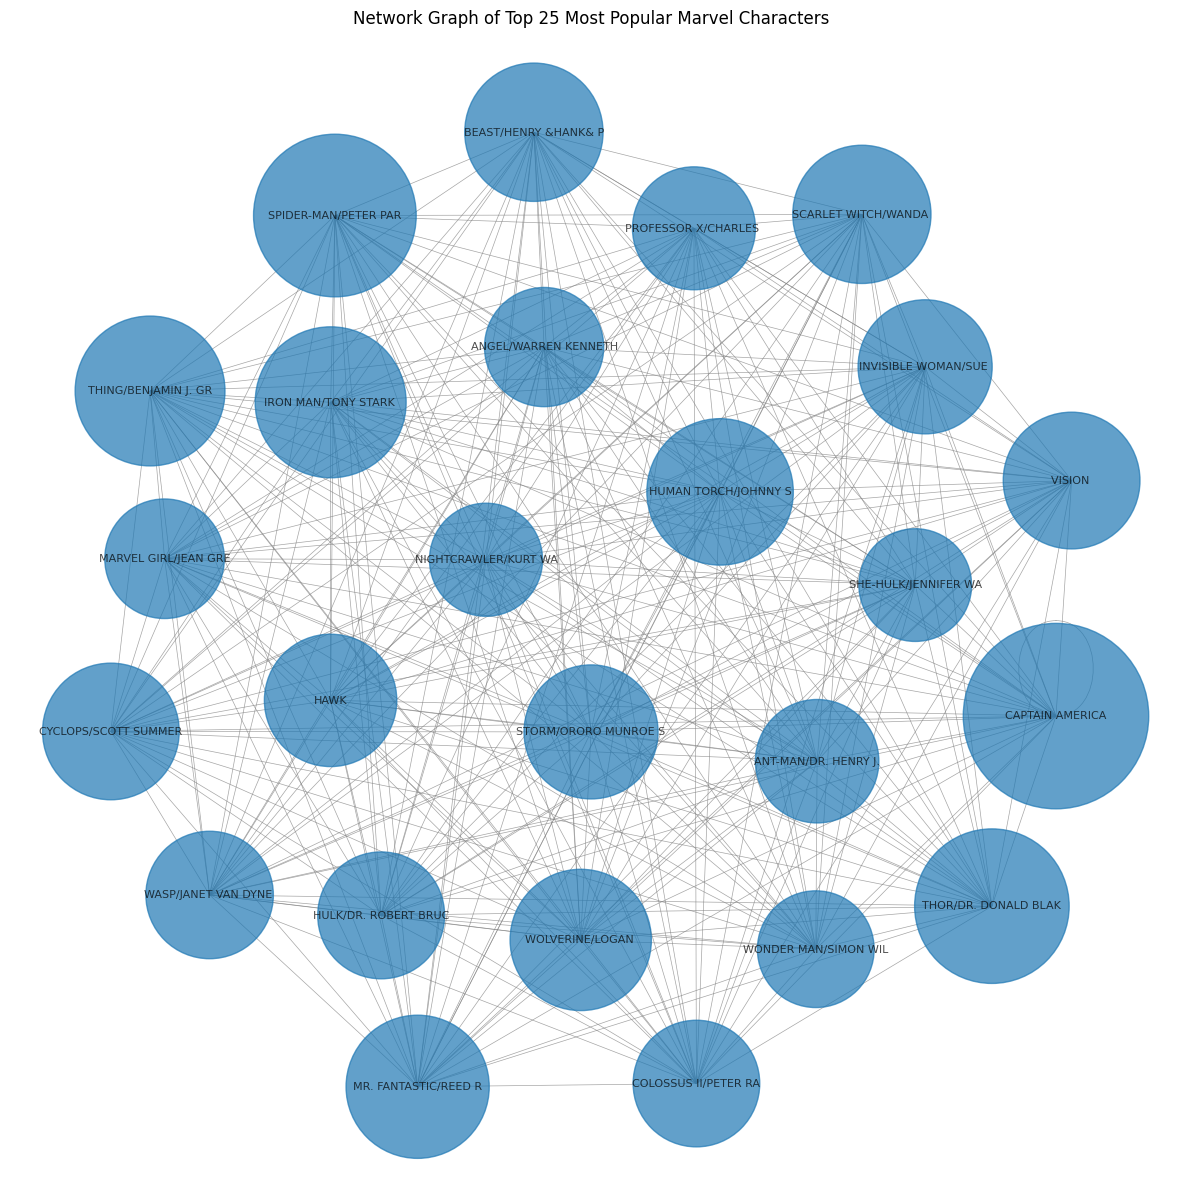

<Figure size 640x480 with 0 Axes>

In [76]:
# ------------------------------------------------------------------------------
# Step 4: Select the top 25 most popular characters
# ------------------------------------------------------------------------------

top_25_popular_characters = popularity_scores.nlargest(25)
print("Top 25 Most Popular Characters:")
print(top_25_popular_characters, "\n")


# ------------------------------------------------------------------------------
# Step 5: Create a network graph of the top 25 popular characters and their connections
# ------------------------------------------------------------------------------

# Generate a list of the top 25 popular characters
popular_characters = top_25_popular_characters.index.tolist()

# Filter the hero-network dataset to include only connections between these top characters
popular_hero_edges = hero_network[(hero_network['hero1'].isin(popular_characters)) |
                                  (hero_network['hero2'].isin(popular_characters))]

# Create Graph
G = nx.Graph()

# Add Nodes
for character in popular_characters:
  # node size based on their popularity
    G.add_node(character, size=top_25_popular_characters[character])

# Add edges
for _, row in popular_hero_edges.iterrows():
    if row['hero1'] in popular_characters and row['hero2'] in popular_characters:
        G.add_edge(row['hero1'], row['hero2'])

# Get node positions
pos = nx.spring_layout(G)

# Draw the network
plt.figure(figsize=(15, 15))
node_sizes = [G.nodes[node]['size'] for node in G]  # Adjust the multiplier as needed
nx.draw_networkx(G, pos, with_labels=True, node_size=node_sizes, alpha=0.7,
                 edge_color='gray', width=0.5, font_size=8)

plt.title('Network Graph of Top 25 Most Popular Marvel Characters')
plt.axis('off')
plt.show()
plt.savefig("/content/Top_25_characters.png")

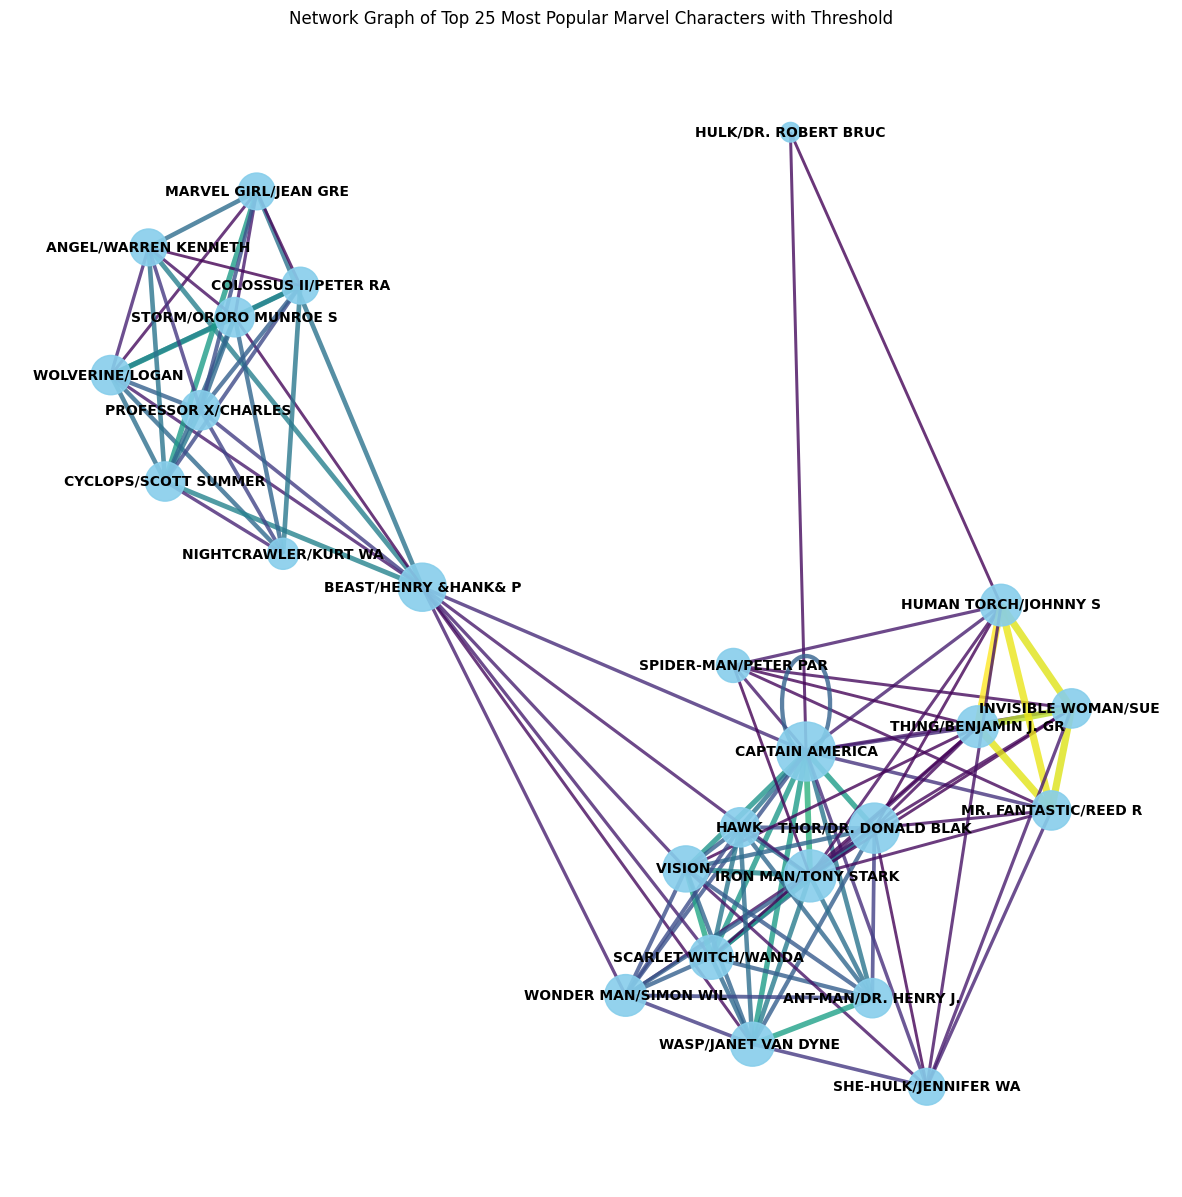

In [77]:
# ------------------------------------------------------------------------------
# Step 6: Redefine graph with connection threshold
# ------------------------------------------------------------------------------

# Calculate the frequency of each hero pair appearing together
hero_pair_frequency = hero_network.groupby(['hero1', 'hero2']).size().reset_index(name='frequency')

# Get the top # of connections
top_connections_number = int(len(hero_pair_frequency) * 0.0025)

# Sort the pairs by frequency
significant_hero_pairs = hero_pair_frequency.nlargest(top_connections_number, 'frequency')


# Create a new graph based on the significant hero pairs
H = nx.Graph()
H.add_nodes_from(popular_characters)
max_weight = max(significant_hero_pairs['frequency'])

for _, row in significant_hero_pairs.iterrows():
    if row['hero1'] in popular_characters and row['hero2'] in popular_characters:
        # Add the edge with the 'frequency' as the weight
        weight = row['frequency'] / max_weight
        H.add_edge(row['hero1'], row['hero2'], weight=weight)

# Draw the network
pos = nx.spring_layout(H, k=.65, iterations=100, seed=12)
plt.figure(figsize=(15, 15))
edge_widths = [H[u][v]['weight']**0.5 * 10 for u,v in H.edges()]
nx.draw_networkx_edges(H, pos, alpha=0.8, edge_color=edge_widths, edge_cmap=plt.cm.viridis, width=edge_widths)

node_sizes = [H.degree(node) * 100 for node in H]  # Draws nodes with size proportional to their degree
nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color='skyblue', alpha=0.9)

nx.draw_networkx_labels(H, pos, font_size=10, font_color='black', font_weight='bold')

plt.title('Network Graph of Top 25 Most Popular Marvel Characters with Threshold')
plt.axis('off')
plt.show()

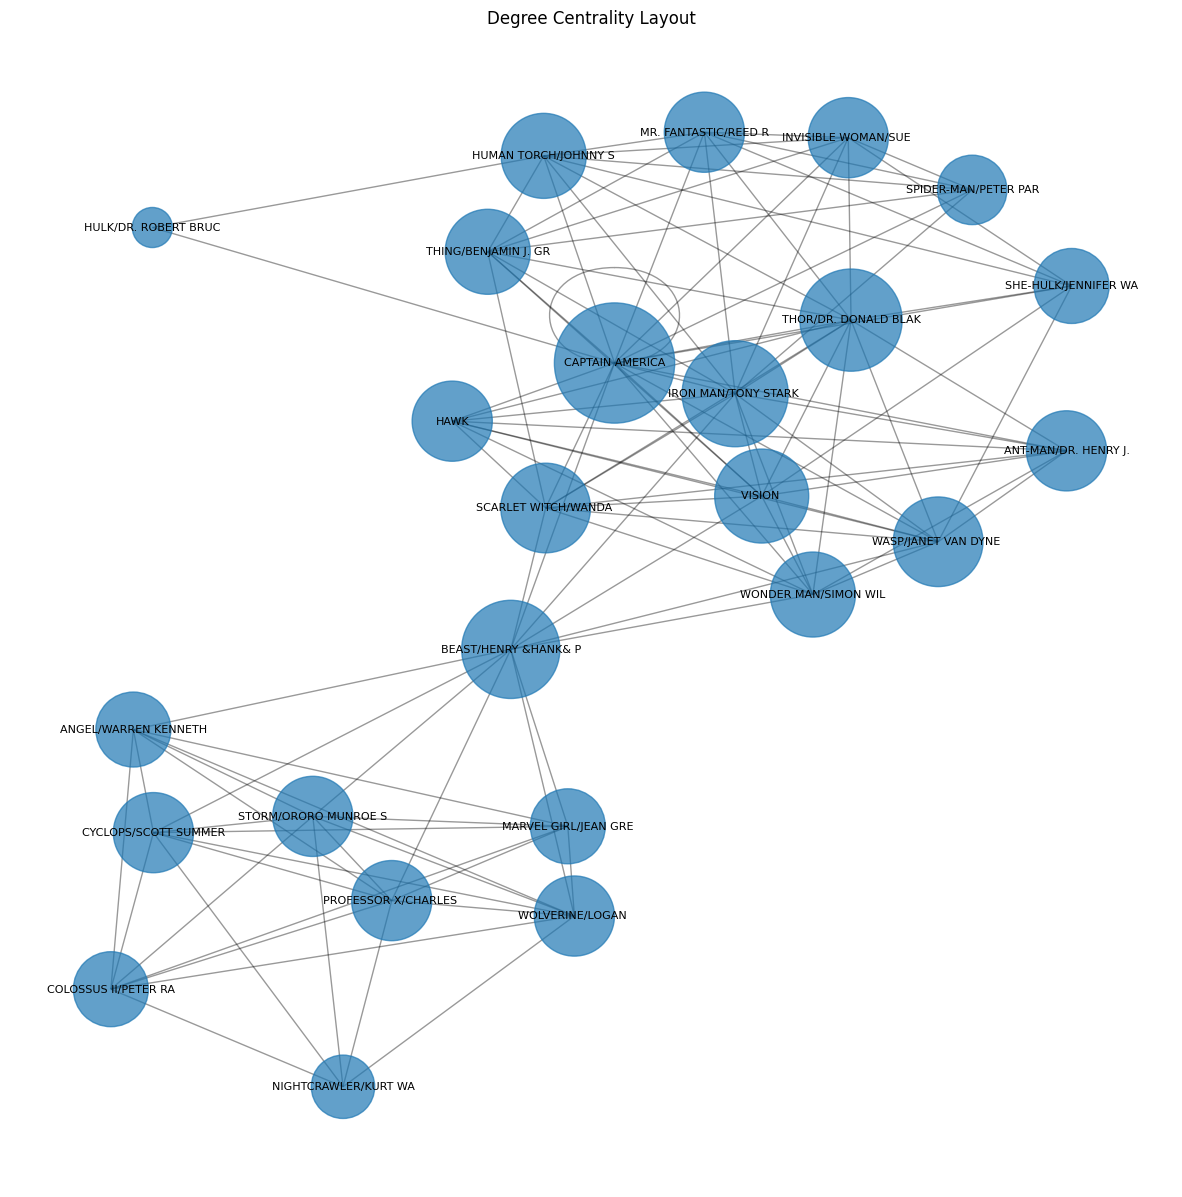

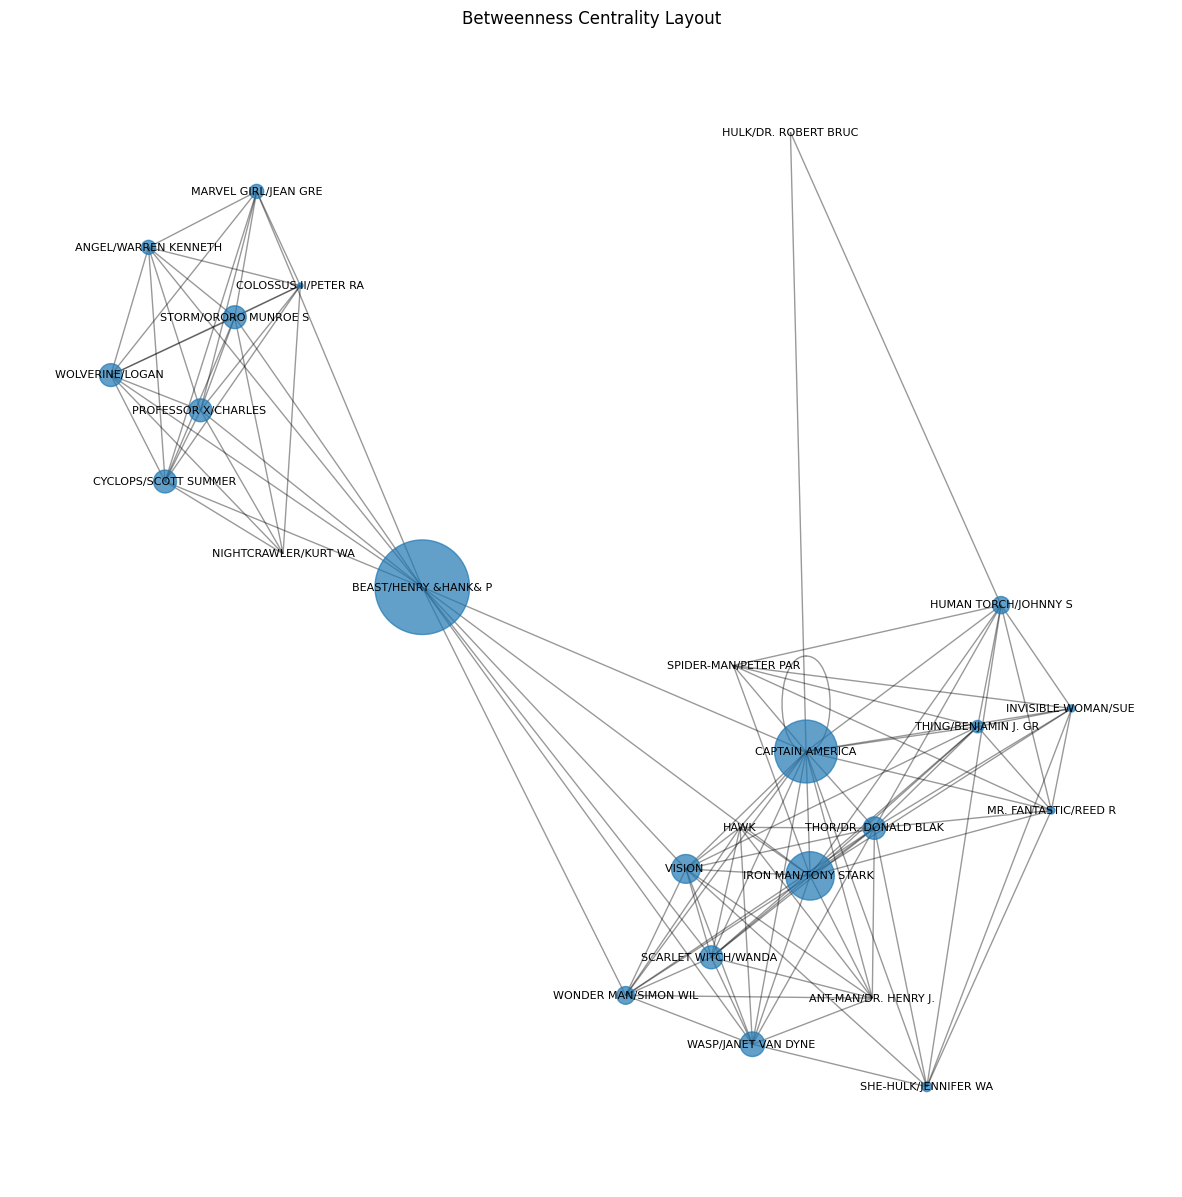

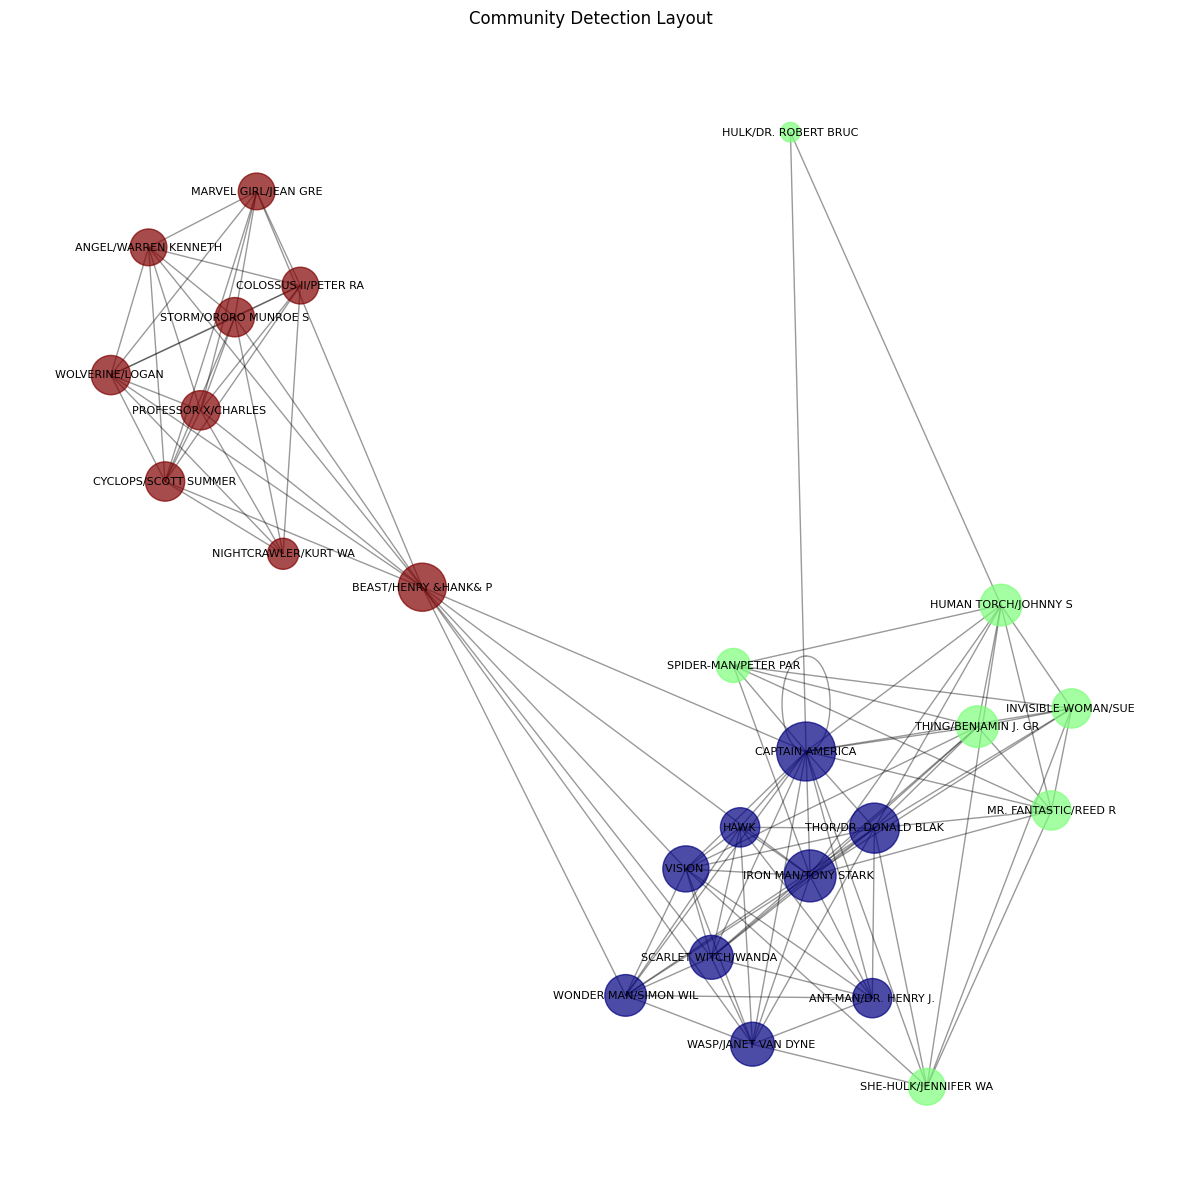

In [78]:
# ------------------------------------------------------------------------------
# Step 7: Explore different network structures
# ------------------------------------------------------------------------------

# -------------------------------
# Degree Centrality Visualization
# -------------------------------
degree_cent = nx.degree_centrality(H)

# Reclaculate positions
pos_degree = nx.kamada_kawai_layout(H, weight=None)

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos_degree, node_size=[v * 10000 for v in degree_cent.values()], alpha=0.7)
nx.draw_networkx_edges(H, pos_degree, alpha=0.4)
nx.draw_networkx_labels(H, pos_degree, font_size=8)
plt.title('Degree Centrality Layout')
plt.axis('off')
plt.show()

# -------------------------------
# Betweenness Centrality Visualization
# -------------------------------
betweenness_cent = nx.betweenness_centrality(H)

# Reclaculate positions
pos_betweenness = nx.kamada_kawai_layout(H, weight=None)

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos, node_size=[v * 10000 for v in betweenness_cent.values()], alpha=0.7)
nx.draw_networkx_edges(H, pos, alpha=0.4)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Betweenness Centrality Layout')
plt.axis('off')
plt.show()

# -------------------------------
# Community Detection Visualization
# -------------------------------
partition = community_louvain.best_partition(H)
community_colors = [partition[node] for node in H.nodes()]

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos, node_size=[H.degree(node) * 100 for node in H], alpha=0.7, node_color=community_colors, cmap=plt.cm.jet)
nx.draw_networkx_edges(H, pos, alpha=0.4)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Community Detection Layout')
plt.axis('off')
plt.show()

In [79]:
# ------------------------------------------------------------------------------
# Step 7: Explore different network structures
# ------------------------------------------------------------------------------

# -------------------------------
# Degree Centrality Visualization
# -------------------------------
degree_cent = nx.degree_centrality(H)

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos, node_size=[v * 10000 for v in degree_cent.values()], alpha=0.7)
nx.draw_networkx_edges(H, pos, alpha=0.4)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Degree Centrality Layout')
plt.axis('off')
plt.show()

nodes_degree_cent_list = [(node, centr) for node, centr in degree_cent.items()]

# Sort nodes by degree centrality
nodes_degree_cent_list.sort(key=lambda x: x[1], reverse=True)

# Layout for degree centrality
pos_degree = {}
center, radius = np.array([0.5, 0.5]), 0.5  # Center and radius of plot
angle_gap = 2 * np.pi / len(H.nodes())
for i, (node, _) in enumerate(nodes_degree_cent_list):
    angle = i * angle_gap
    pos_degree[node] = center + radius * np.array([np.cos(angle), np.sin(angle)]) * (1 - degree_cent[node])

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos_degree, node_size=[v * 10000 for v in degree_cent.values()], alpha=0.7)
nx.draw_networkx_edges(H, pos_degree, alpha=0.4)
nx.draw_networkx_labels(H, pos_degree, font_size=8)
plt.title('Degree Centrality Layout')
plt.axis('off')
plt.show()

# -------------------------------
# Betweenness Centrality Visualization
# -------------------------------
betweenness_cent = nx.betweenness_centrality(H)

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos, node_size=[v * 10000 for v in betweenness_cent.values()], alpha=0.7)
nx.draw_networkx_edges(H, pos, alpha=0.4)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Betweenness Centrality Layout')
plt.axis('off')
plt.show()

nodes_betweenness_cent_list = [(node, centr) for node, centr in betweenness_cent.items()]

# Sort nodes by betweenness centrality
nodes_betweenness_cent_list.sort(key=lambda x: x[1], reverse=True)

# Layout for betweenesss centrality
pos_betweenness = {}
for i, (node, _) in enumerate(nodes_betweenness_cent_list):
    angle = i * angle_gap
    pos_betweenness[node] = center + radius * np.array([np.cos(angle), np.sin(angle)]) * (1 - betweenness_cent[node])

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos_betweenness, node_size=[v * 10000 for v in betweenness_cent.values()], alpha=0.7)
nx.draw_networkx_edges(H, pos_betweenness, alpha=0.4)
nx.draw_networkx_labels(H, pos_betweenness, font_size=8)
plt.title('Betweenness Centrality Layout')
plt.axis('off')
plt.show()

# -------------------------------
# Closeness Centrality Visualization
# -------------------------------
closeness_cent = nx.closeness_centrality(H)

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos, node_size=[v * 10000 for v in closeness_cent.values()], alpha=0.7)
nx.draw_networkx_edges(H, pos, alpha=0.4)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Closeness Centrality Layout')
plt.axis('off')
plt.show()


nodes_closeness_cent_list = [(node, centr) for node, centr in closeness_cent.items()]

# Sort nodes by closeness centrality
nodes_closeness_cent_list.sort(key=lambda x: x[1], reverse=True)

# Layout for closeness centrality
pos_closeness = {}
for i, (node, _) in enumerate(nodes_closeness_cent_list):
    angle = i * angle_gap
    pos_closeness[node] = center + radius * np.array([np.cos(angle), np.sin(angle)]) * (1 - closeness_cent[node])

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos_closeness, node_size=[v * 10000 for v in closeness_cent.values()], alpha=0.7)
nx.draw_networkx_edges(H, pos_closeness, alpha=0.4)
nx.draw_networkx_labels(H, pos_closeness, font_size=8)
plt.title('Closeness Centrality Layout')
plt.axis('off')
plt.show()

# -------------------------------
# Eigenvector Centrality Visualization
# -------------------------------
eigenvector_cent = nx.eigenvector_centrality(H)

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos, node_size=[v * 10000 for v in eigenvector_cent.values()], alpha=0.7)
nx.draw_networkx_edges(H, pos, alpha=0.4)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Eigenvector Centrality Layout')
plt.axis('off')
plt.show()


nodes_eigenvector_cent_list = [(node, centr) for node, centr in eigenvector_cent.items()]

# Sort nodes by eigenvector centrality
nodes_eigenvector_cent_list.sort(key=lambda x: x[1], reverse=True)

# Layout for eigenvector centrality
pos_eigenvector = {}
for i, (node, _) in enumerate(nodes_eigenvector_cent_list):
    angle = i * angle_gap
    pos_eigenvector[node] = center + radius * np.array([np.cos(angle), np.sin(angle)]) * (1 - eigenvector_cent[node])

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos_eigenvector, node_size=[v * 10000 for v in eigenvector_cent.values()], alpha=0.7)
nx.draw_networkx_edges(H, pos_eigenvector, alpha=0.4)
nx.draw_networkx_labels(H, pos_eigenvector, font_size=8)
plt.title('Eigenvector Centrality Layout')
plt.axis('off')
plt.show()

# -------------------------------
# Community Detection Visualization
# -------------------------------
partition = community_louvain.best_partition(H)
community_colors = [partition[node] for node in H.nodes()]

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos, node_size=[H.degree(node) * 100 for node in H], alpha=0.7, node_color=community_colors, cmap=plt.cm.jet)
nx.draw_networkx_edges(H, pos, alpha=0.4)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Community Detection Layout')
plt.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

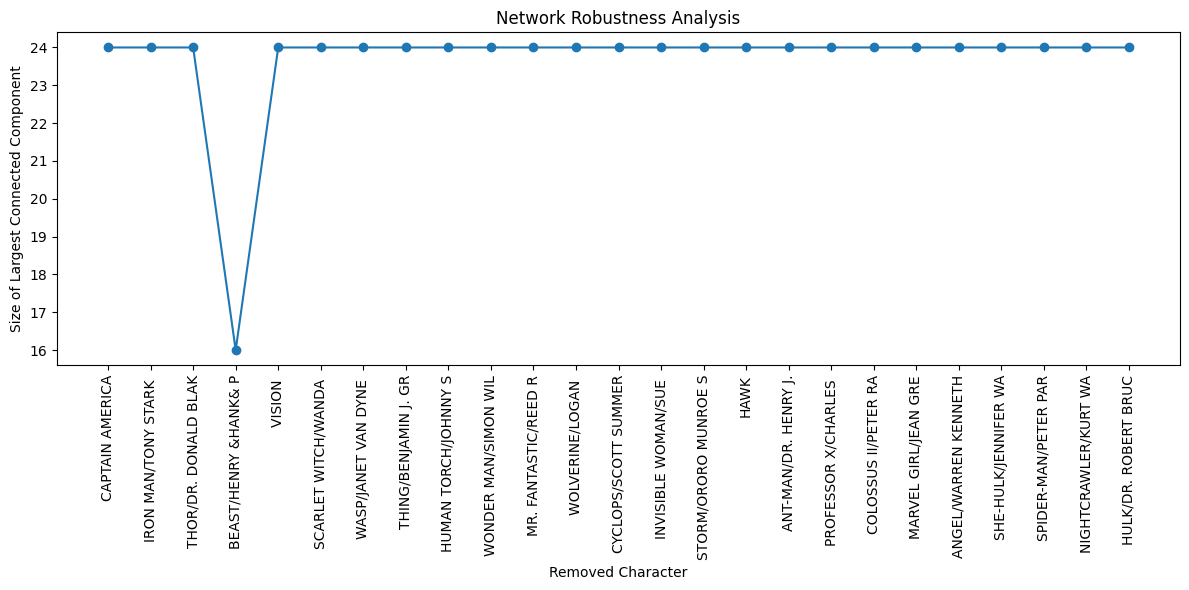

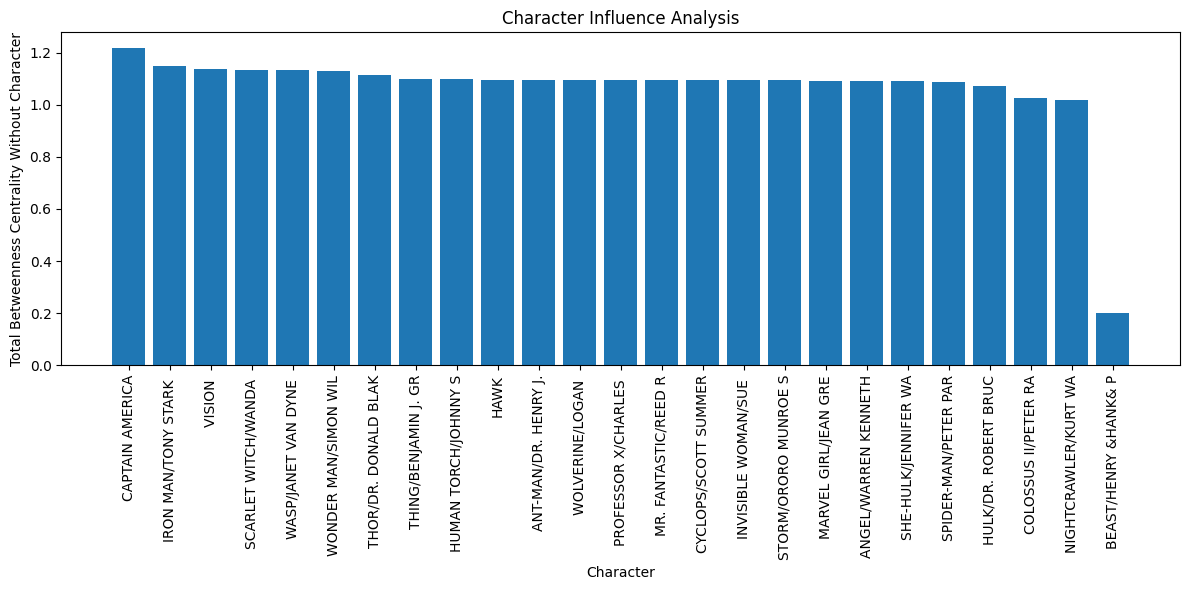

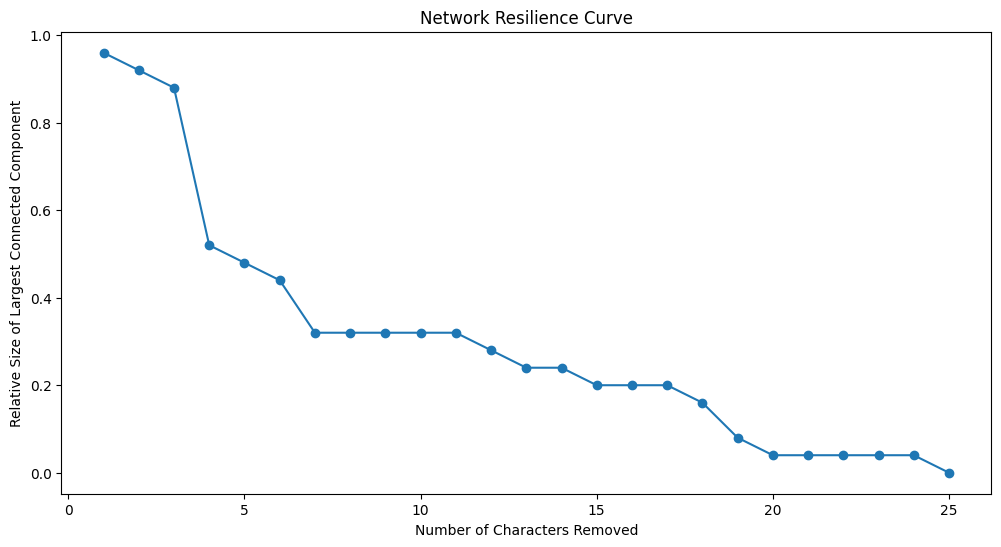

In [80]:
# ------------------------------------------------------------------------------
# Step 8: Network Robustness and Influence Analysis
# ------------------------------------------------------------------------------

# Identify Key Characters based on Degree Centrality
degree_centrality = nx.degree_centrality(H)
key_characters = sorted(degree_centrality, key=degree_centrality.get, reverse=True)

# Evluates robustness of the network
def evaluate_network_robustness(H, key_characters):
    robustness_report = []
    temp_H = H.copy()
    for character in key_characters:
        # Remove a Character
        temp_H.remove_node(character)
        # Find size of the largest connected component
        largest_cc_size = len(max(nx.connected_components(temp_H), key=len))
        robustness_report.append(largest_cc_size)
        # Revert removal
        temp_H = H.copy()
    return robustness_report

# Evaluate and plot the robustness of the network
robustness_report = evaluate_network_robustness(H, key_characters)
plt.figure(figsize=(12, 6))
plt.plot(key_characters, robustness_report, marker='o')
plt.title('Network Robustness Analysis')
plt.xlabel('Removed Character')
plt.ylabel('Size of Largest Connected Component')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Evaluates influence of character removal
def evaluate_character_influence(H, key_characters):
    influence_report = {}
    for character in key_characters:
        # Calculate the betweenness centrality of the network without the character
        temp_H = H.copy()
        temp_H.remove_node(character)
        betweenness_centrality_without_character = nx.betweenness_centrality(temp_H)
        total_centrality = sum(betweenness_centrality_without_character.values())
        influence_report[character] = total_centrality
    return influence_report

# Get influence report
influence_report = evaluate_character_influence(H, key_characters)
sorted_influence_report = sorted(influence_report.items(), key=lambda item: item[1], reverse=True)

# Plot the influence of characters
plt.figure(figsize=(12, 6))
plt.bar([item[0] for item in sorted_influence_report], [item[1] for item in sorted_influence_report])
plt.title('Character Influence Analysis')
plt.xlabel('Character')
plt.ylabel('Total Betweenness Centrality Without Character')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Evaluate network resilience
def simulate_network_resilience(H, centrality_measure):
    resilience_curve = []
    temp_H = H.copy()
    sorted_nodes = sorted(centrality_measure, key=centrality_measure.get, reverse=True)

    for i in range(1, len(sorted_nodes) + 1):
        nodes_to_remove = sorted_nodes[:i]
        temp_H.remove_nodes_from(nodes_to_remove)
        largest_cc_size = len(max(nx.connected_components(temp_H), key=len)) if nx.number_connected_components(temp_H) > 0 else 0
        resilience_curve.append(largest_cc_size / len(H.nodes()))
    return resilience_curve

# Plot network resilience curve
resilience_curve = simulate_network_resilience(H, degree_cent)
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(H.nodes()) + 1), resilience_curve, marker='o')
plt.title('Network Resilience Curve')
plt.xlabel('Number of Characters Removed')
plt.ylabel('Relative Size of Largest Connected Component')

plt.show()

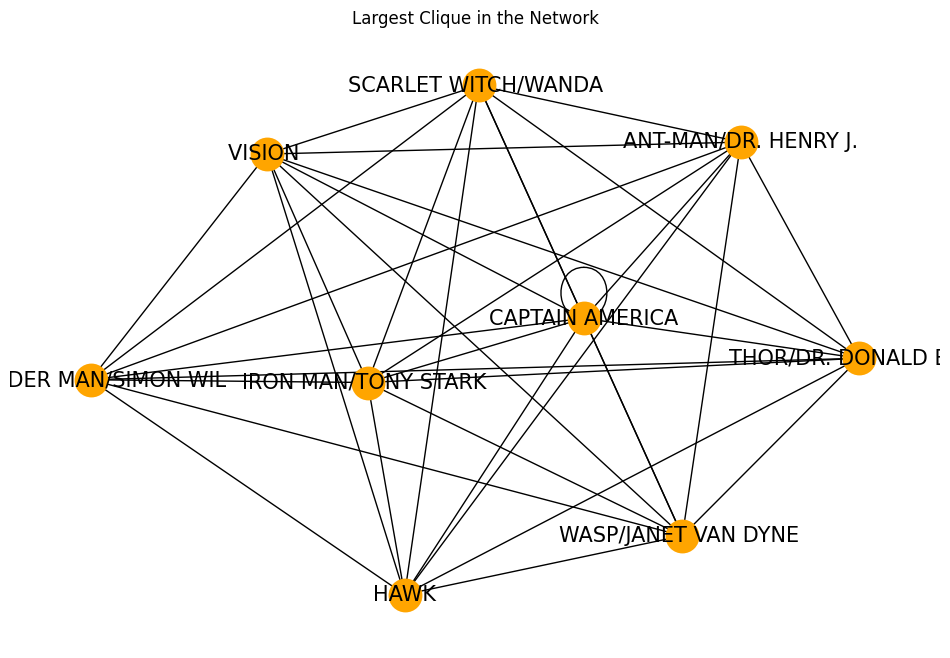

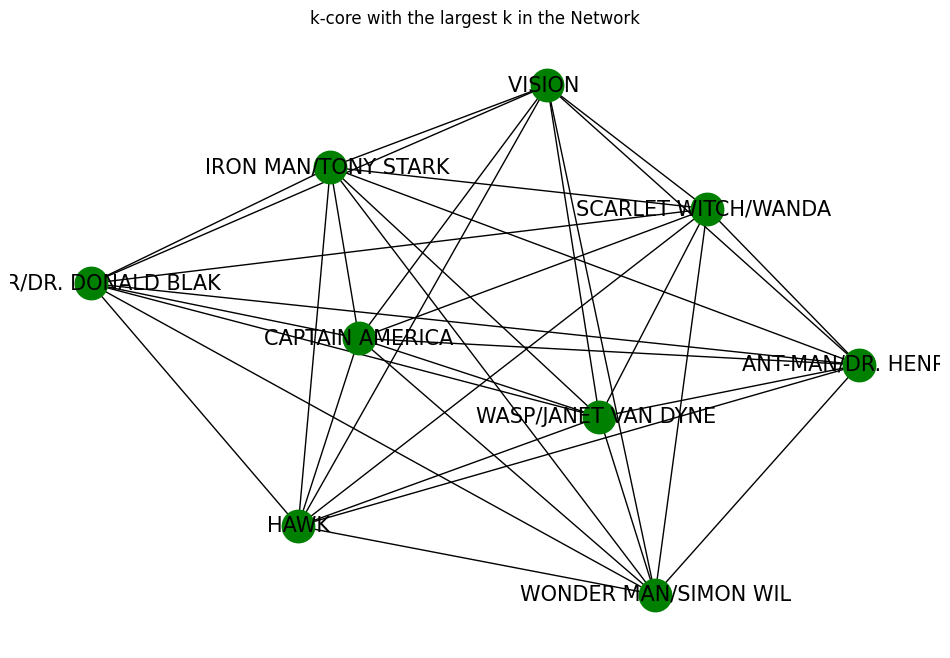

In [81]:
# A k-core of a network is a maximal connected subgraph in which each vertex has
# at least degree k. It's a subgraph where each node is connected to at least k
# other nodes within the subgraph. This is used to analyze cohesiveness and
# identify tightly connected communities
# ------------------------------------------------------------------------------
# Step 9: Analysis for Character Cliques and Alliances
# ------------------------------------------------------------------------------
cliques = list(nx.find_cliques(H))
largest_clique = max(cliques, key=len)

# Visualize the largest clique
plt.figure(figsize=(12, 8))
clique_graph = H.subgraph(largest_clique)
pos_clique = nx.spring_layout(clique_graph)
nx.draw_networkx(clique_graph, pos_clique, with_labels=True, node_color='orange', node_size=500, edge_color='black', linewidths=2, font_size=15)
plt.title('Largest Clique in the Network')
plt.axis('off')
plt.show()

# Alliance Analysis using k-cores
H.remove_edges_from(nx.selfloop_edges(H))
core_number = nx.core_number(H)
largest_k = max(core_number.values())
k_core_graph = nx.k_core(H, k=largest_k)

# Visualize the k-core
plt.figure(figsize=(12, 8))
pos_k_core = nx.spring_layout(k_core_graph)
nx.draw_networkx(k_core_graph, pos_k_core, with_labels=True, node_color='green', node_size=500, edge_color='black', linewidths=2, font_size=15)
plt.title('k-core with the largest k in the Network')
plt.axis('off')
plt.show()

# **Generative Models**

Erdos-Renyi Model


For p = 0.010, Average Degree: 0.16, Clustering Coefficient: 0.0000
For p = 0.062, Average Degree: 1.36, Clustering Coefficient: 0.0573
For p = 0.114, Average Degree: 2.24, Clustering Coefficient: 0.0000
For p = 0.166, Average Degree: 4.24, Clustering Coefficient: 0.2111
For p = 0.218, Average Degree: 6.56, Clustering Coefficient: 0.3126
For p = 0.271, Average Degree: 5.84, Clustering Coefficient: 0.2275
For p = 0.323, Average Degree: 8.08, Clustering Coefficient: 0.2858
For p = 0.375, Average Degree: 8.48, Clustering Coefficient: 0.3675
For p = 0.427, Average Degree: 10.16, Clustering Coefficient: 0.4156
For p = 0.479, Average Degree: 10.96, Clustering Coefficient: 0.4429
For p = 0.531, Average Degree: 13.28, Clustering Coefficient: 0.5397
For p = 0.583, Average Degree: 12.48, Clustering Coefficient: 0.5154
For p = 0.635, Average Degree: 15.12, Clustering Coefficient: 0.6300
For p = 0.687, Average Degree: 16.32, Clustering Coefficient: 0.6794
For p = 0.739, Average Degree: 16.16, Clus

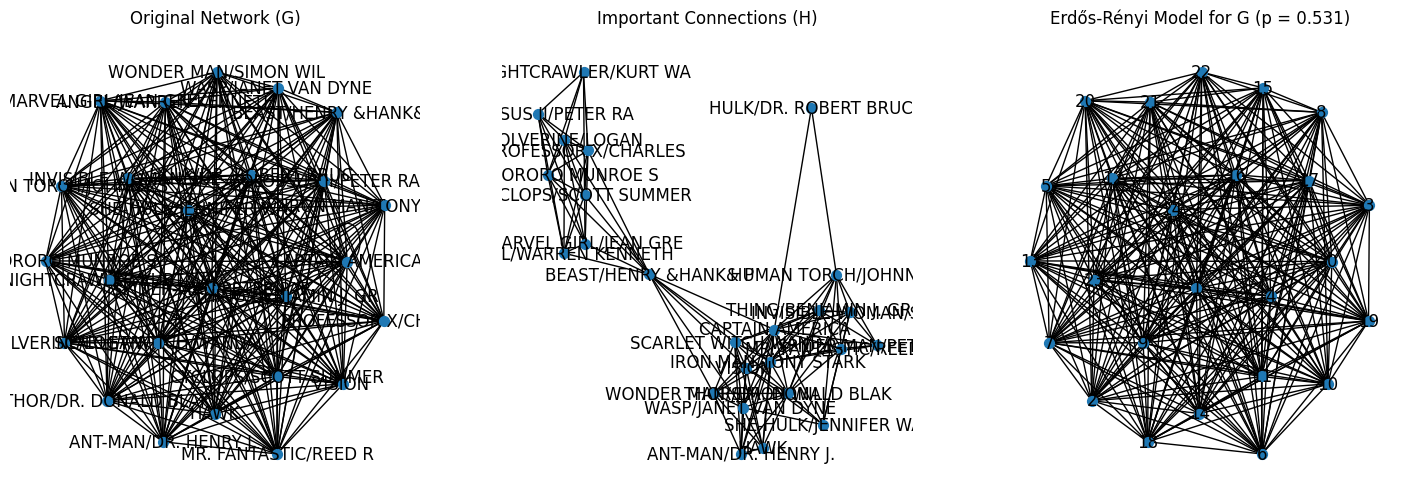

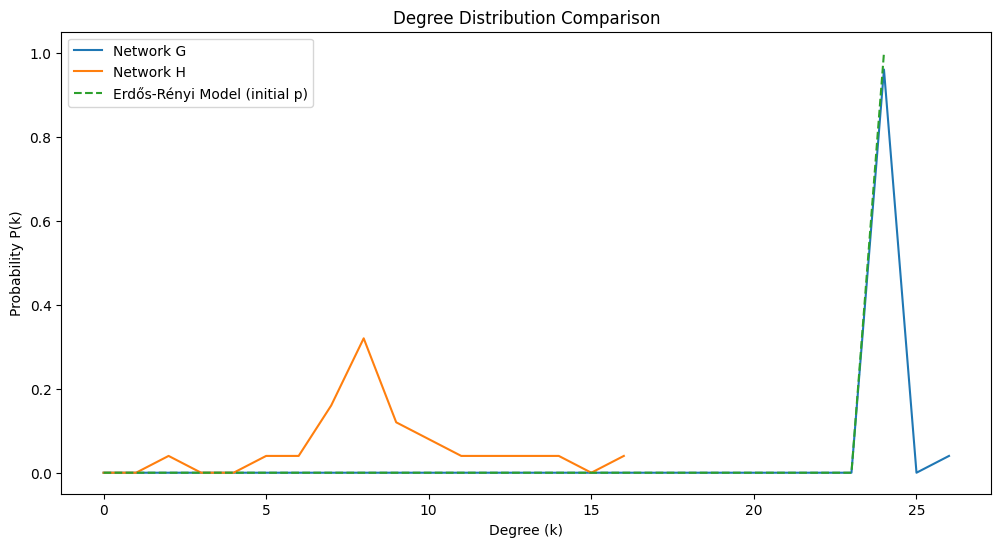

We will now focus on properties of the most important graph edges H since G simulates a complete graph.
Average Degree - Network G: 24.08, Network H: 8.72
Clustering Coefficient - Network G: 1.0000, Network H: 0.8230


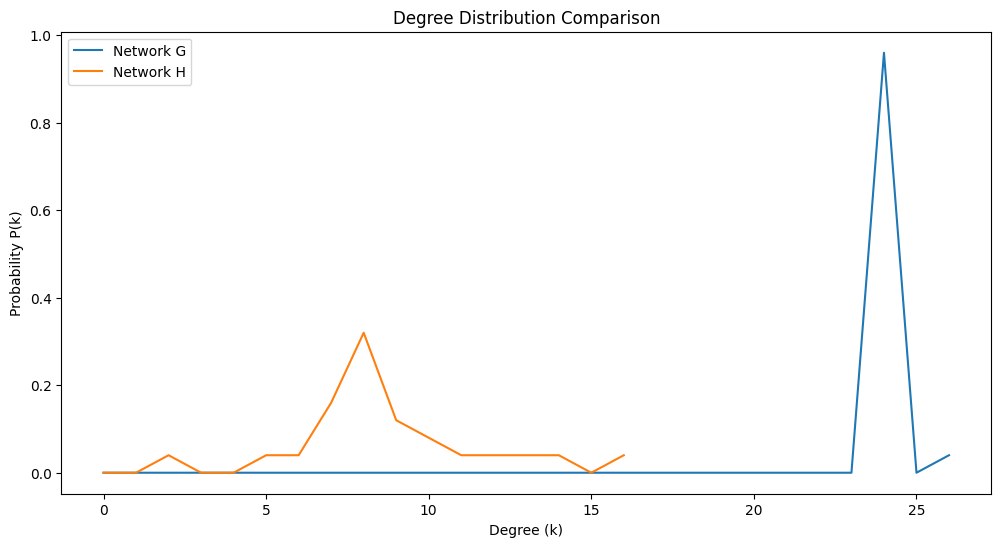

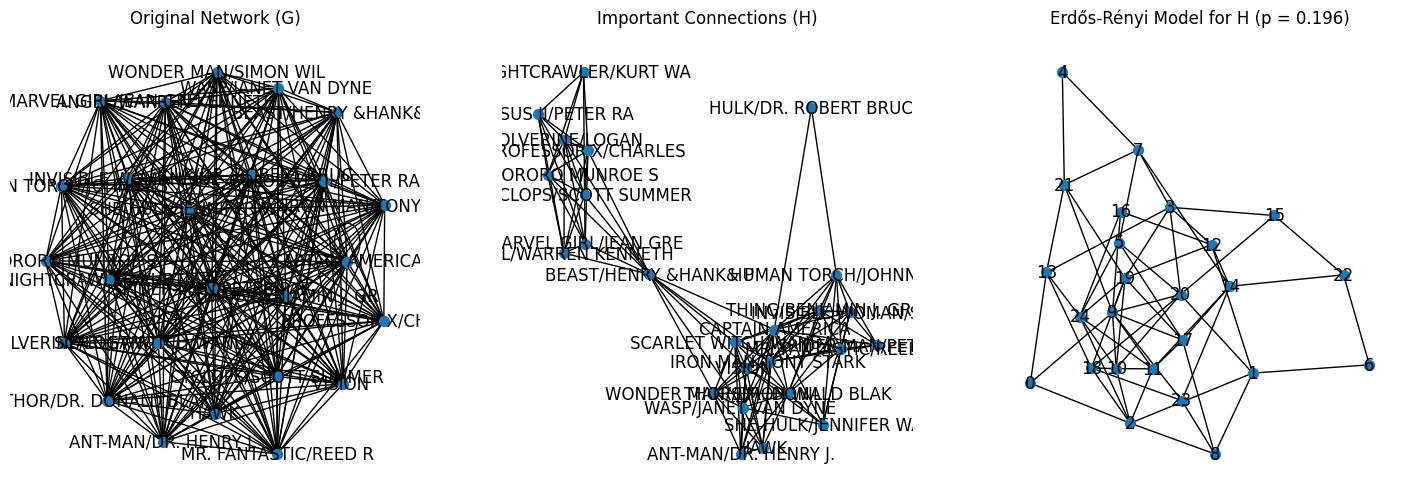

In [82]:
# ------------------------------------------------------------------------------
# Step 1: Generate Erdős-Rényi Model and Compare Network Metrics for Varying p
# ------------------------------------------------------------------------------
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Function to calculate degree distribution
def degree_distribution(graph):
    degrees = [degree for node, degree in graph.degree()]
    max_degree = max(degrees)
    degree_count = np.zeros(max_degree + 1)
    for degree in degrees:
        degree_count[degree] += 1
    degree_count /= num_nodes
    return degree_count

# Calculate initial probability p for the Erdős-Rényi model
initial_p = num_edges / (num_nodes * (num_nodes - 1) / 2)

# Varying p from 0.01 to initial_p by increments, exploring below and around the initial estimate
p_values_G = np.linspace(0.01, min(1, initial_p), 20)

# Dictionary to hold graphs for different p values
ER_graphs_G = {}

for p in p_values_G:
    ER_graph = nx.erdos_renyi_graph(num_nodes, p)
    ER_graphs_G[p] = ER_graph

    # Calculate and print network metrics
    avg_degree = np.mean([degree for node, degree in ER_graph.degree()])
    cc = nx.average_clustering(ER_graph)
    print(f"For p = {p:.3f}, Average Degree: {avg_degree:.2f}, Clustering Coefficient: {cc:.4f}")

# Plot Graphs G, H, and one ER
def plot_graph(graph, title, p, position):
    plt.subplot(1, 3, position)
    pos = nx.spring_layout(graph, seed=42)
    nx.draw_networkx(graph, pos, with_labels=True, node_size=50)
    # Check if p is not empty or zero
    if p == '':
      plt.title(title)
    else:
      p_float = float(p)
      plt.title(f"{title} (p = {p_float:.3f})")
    plt.axis('off')

# Calculate and Display Network Metrics for G and H
degree_dist_H = degree_distribution(H)
avg_degree_H = np.mean(list(dict(H.degree()).values()))
cc_H = nx.average_clustering(H)
degree_dist_G = degree_distribution(G)
avg_degree_G = np.mean(list(dict(G.degree()).values()))
cc_G = nx.average_clustering(G)
degree_dist_ER = degree_distribution(ER_graph)

print(f"Average Degree - Network G: {avg_degree_G:.2f}, Network H: {avg_degree_H:.2f}")
print(f"Clustering Coefficient - Network G: {cc_G:.4f}, Network H: {cc_H:.4f}")

# Select a graph from the middle of the probability range for G
middle_index_G = len(p_values_G) // 2
selected_p_G = p_values_G[middle_index_G]
selected_ER_graph_G = ER_graphs_G[selected_p_G]

plt.figure(figsize=(18, 6))
plot_graph(G, 'Original Network (G)', '', 1)
plot_graph(H, 'Important Connections (H)', '', 2)
plot_graph(ER_graph, 'Erdős-Rényi Model for G', selected_p_G, 3)
plt.show()

# Visual Comparison of Degree Distributions for G, H, and one of the ER graphs
plt.figure(figsize=(12, 6))
plt.plot(degree_dist_G, label='Network G')
plt.plot(degree_dist_H, label='Network H')
plt.plot(degree_dist_ER, label='Erdős-Rényi Model (initial p)', linestyle='--')
plt.xlabel('Degree (k)')
plt.ylabel('Probability P(k)')
plt.title('Degree Distribution Comparison')
plt.legend()
plt.show()

# Plot Graphs G, H, and one ER
def plot_graph(graph, title, p, position):
    plt.subplot(1, 3, position)
    pos = nx.spring_layout(graph, seed=42)
    nx.draw_networkx(graph, pos, with_labels=True, node_size=50)
    # Check if p is not empty or zero
    if p == '':
      plt.title(title)
    else:
      p_float = float(p)
      plt.title(f"{title} (p = {p_float:.3f})")
    plt.axis('off')

# Now focusing on properties from H
num_nodes_H = H.number_of_nodes()
num_edges_H = H.number_of_edges()

# Calculate initial probability p for the Erdős-Rényi model using H
initial_p_H = num_edges_H / (num_nodes_H * (num_nodes_H - 1) / 2)

# Generate ER graphs using properties from H
ER_graphs_H = {}
p_values_H = np.linspace(0.01, min(1, initial_p_H), 20)
for p in p_values_H:
    ER_graph = nx.erdos_renyi_graph(num_nodes_H, p)
    ER_graphs_H[p] = ER_graph

# Select a graph from the middle of the probability range for H
middle_index_H = len(p_values_H) // 2
selected_p_H = p_values_H[middle_index_H]
selected_ER_graph_H = ER_graphs_H[selected_p_H]

# Calculate and Display Network Metrics for G and H
degree_dist_H = degree_distribution(H)
avg_degree_H = np.mean(list(dict(H.degree()).values()))
cc_H = nx.average_clustering(H)
degree_dist_G = degree_distribution(G)
avg_degree_G = np.mean(list(dict(G.degree()).values()))
cc_G = nx.average_clustering(G)

print("We will now focus on properties of the most important graph edges H since G simulates a complete graph.")
print(f"Average Degree - Network G: {avg_degree_G:.2f}, Network H: {avg_degree_H:.2f}")
print(f"Clustering Coefficient - Network G: {cc_G:.4f}, Network H: {cc_H:.4f}")

# Plot degree distributions
plt.figure(figsize=(12, 6))
plt.plot(degree_dist_G, label='Network G')
plt.plot(degree_dist_H, label='Network H')
plt.xlabel('Degree (k)')
plt.ylabel('Probability P(k)')
plt.title('Degree Distribution Comparison')
plt.legend()
plt.show()

# Plotting
plt.figure(figsize=(18, 6))
plot_graph(G, 'Original Network (G)', '', 1)
plot_graph(H, 'Important Connections (H)', '', 2)
plot_graph(selected_ER_graph_H, 'Erdős-Rényi Model for H', selected_p_H, 3)
plt.show()

Barabasi-Albert Model

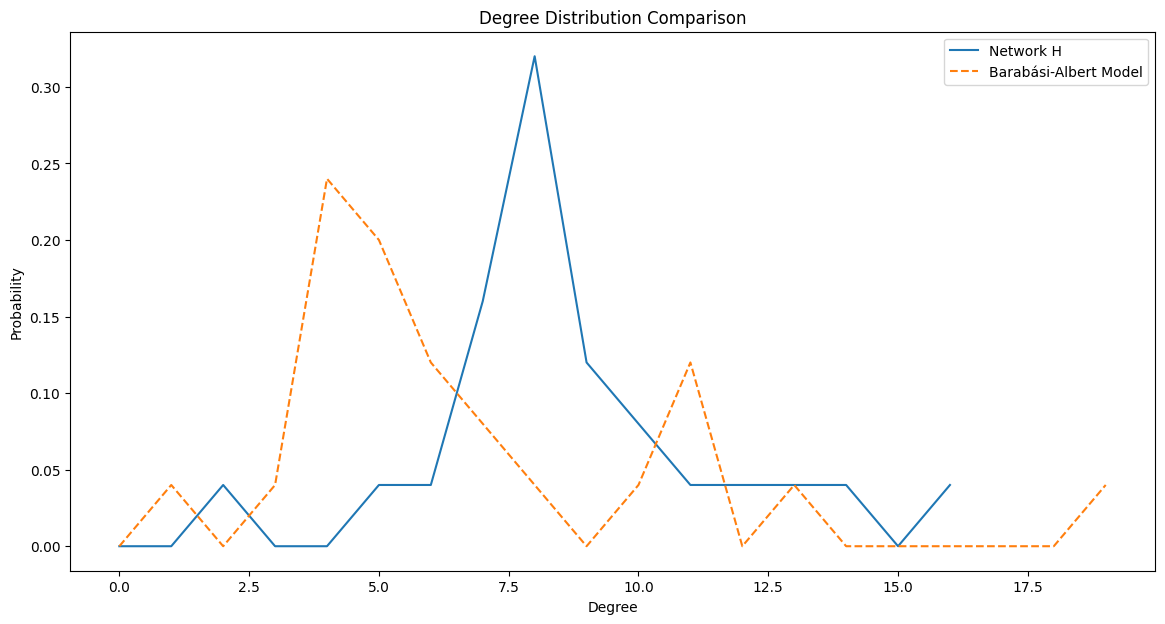

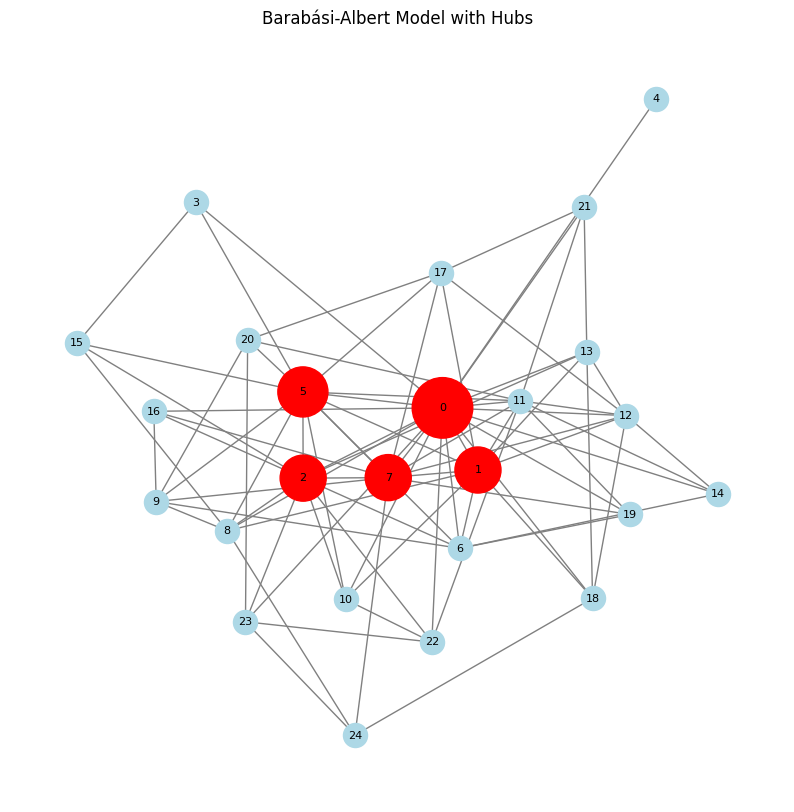

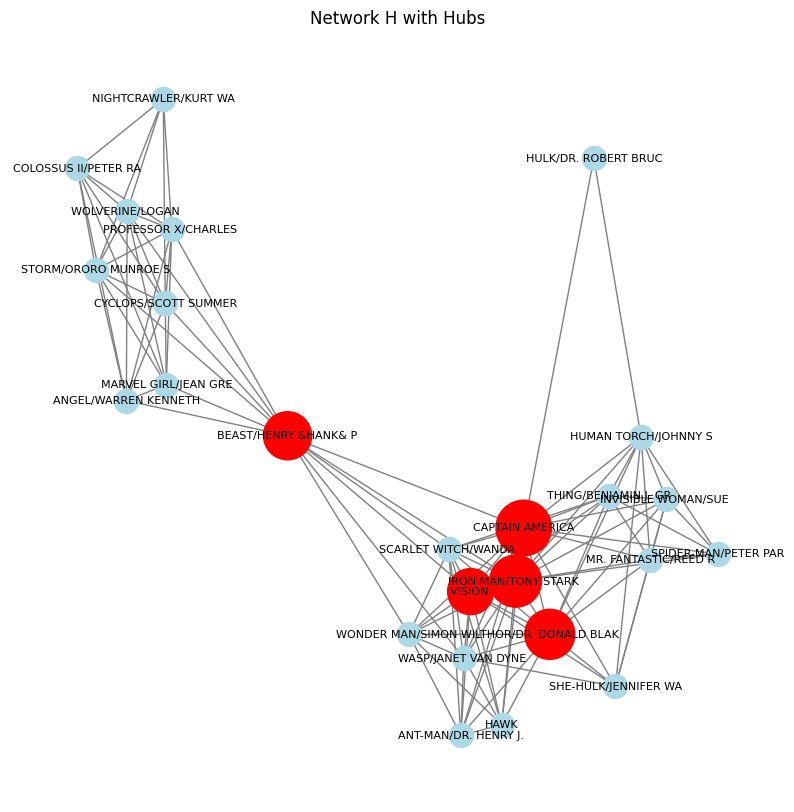

Discussion:
Barabási-Albert Model Metrics: Average Degree = 6.72, Clustering Coefficient = 0.4325
Original Network H Metrics: Average Degree = 8.72, Clustering Coefficient = 0.8230

Insights:
The hub analysis reveals that both networks have nodes with significantly higher connectivity.
In scale-free networks like the BA model, hubs are expected and illustrate the 'rich-get-richer' phenomenon.
If Network H shows a similar pattern with distinct hubs, it suggests that certain characters, like major superheroes, play a central role in connecting various parts of the network.


In [83]:
# Degree distribution function
def degree_distribution(graph):
    degree_dict = dict(graph.degree())
    max_degree = max(degree_dict.values())
    degree_count = np.zeros(max_degree + 1)
    for degree in degree_dict.values():
        degree_count[degree] += 1
    degree_count /= len(graph.nodes())
    return degree_count

# Generate a BA graph
def generate_ba_graph(n, m):
    return nx.barabasi_albert_graph(n, m)

# Parameters and BA graph
num_nodes_H = len(H.nodes())
m_parameter = int(avg_degree_H / 2)
BA_graph = generate_ba_graph(num_nodes_H, m_parameter)

# Degree distributions
degree_dist_BA = degree_distribution(BA_graph)
degree_dist_H = degree_distribution(H)

# Visualization of the degree distributions
plt.figure(figsize=(14, 7))
plt.plot(degree_dist_H, label='Network H')
plt.plot(degree_dist_BA, label='Barabási-Albert Model', linestyle='--')
plt.title('Degree Distribution Comparison')
plt.xlabel('Degree')
plt.ylabel('Probability')
plt.legend()
plt.show()

# Network metrics calculation
ba_avg_degree = np.mean([d for n, d in BA_graph.degree()])
ba_cc = nx.average_clustering(BA_graph)
h_avg_degree = np.mean([d for n, d in H.degree()])
h_cc = nx.average_clustering(H)

# Hub analysis: Identify and visualize the top 5 hubs
top_hubs_BA = sorted(BA_graph.degree, key=lambda x: x[1], reverse=True)[:5]
top_hubs_H = sorted(H.degree, key=lambda x: x[1], reverse=True)[:5]

def plot_graph_with_hubs(graph, hubs, title):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(graph, seed=42)
    nx.draw_networkx_nodes(graph, pos, node_color='lightblue')
    nx.draw_networkx_edges(graph, pos, edge_color='gray')
    # Highlight hubs
    hub_names = [hub[0] for hub in hubs]
    sizes = [hub[1]*100 for hub in hubs]  # Scale for visibility
    nx.draw_networkx_nodes(graph, pos, nodelist=hub_names, node_size=sizes, node_color='red')
    nx.draw_networkx_labels(graph, pos, font_size=8)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Visualizing both networks with hubs highlighted
plot_graph_with_hubs(BA_graph, top_hubs_BA, 'Barabási-Albert Model with Hubs')
plot_graph_with_hubs(H, top_hubs_H, 'Network H with Hubs')

# Discussion of findings with hub analysis included
print("Discussion:")
print(f"Barabási-Albert Model Metrics: Average Degree = {ba_avg_degree:.2f}, Clustering Coefficient = {ba_cc:.4f}")
print(f"Original Network H Metrics: Average Degree = {h_avg_degree:.2f}, Clustering Coefficient = {h_cc:.4f}")
print("\nInsights:")
print("The hub analysis reveals that both networks have nodes with significantly higher connectivity.")
print("In scale-free networks like the BA model, hubs are expected and illustrate the 'rich-get-richer' phenomenon.")
print("If Network H shows a similar pattern with distinct hubs, it suggests that certain characters, like major superheroes, play a central role in connecting various parts of the network.")


This phenomenon is often referred to as the "rich-get-richer" effect. The presence of similar hubs in Network H suggests that the network may exhibit scale-free properties. This is particularly relevant in social and collaboration networks, where some individuals or entities (in this case, characters like major superheroes) hold disproportionate influence over the network's connectivity and topology


Watts-Strogatz Model

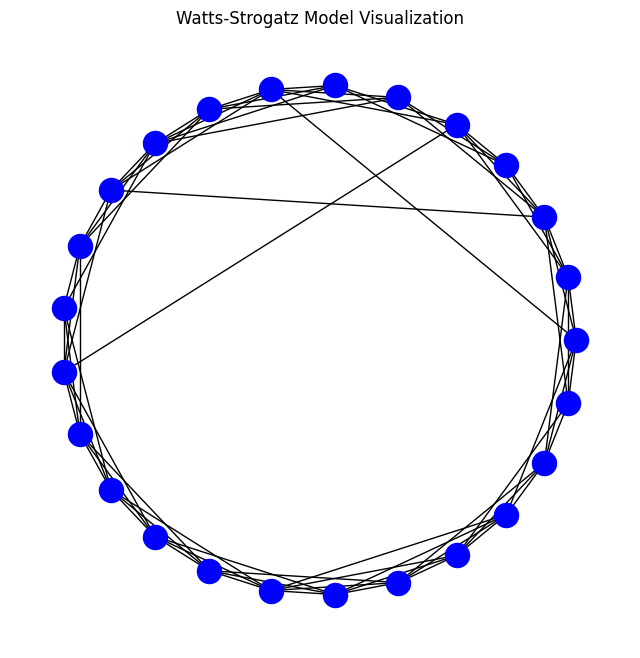

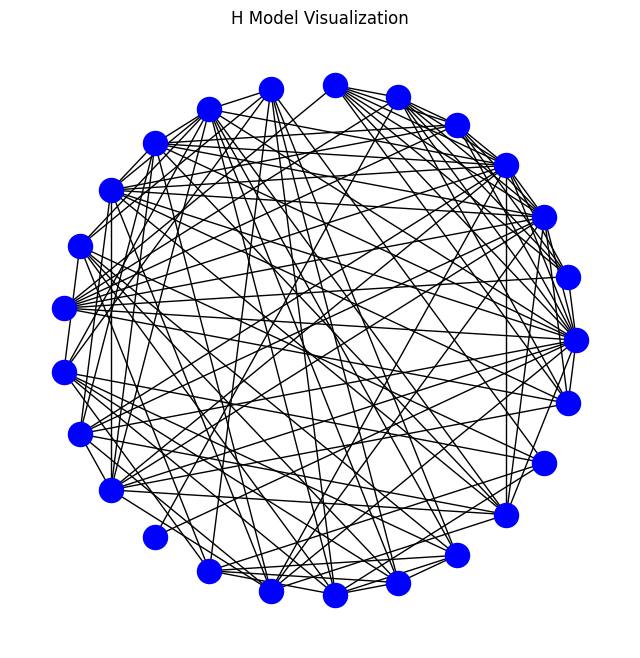

Watts-Strogatz Metrics:
Clustering Coefficient: 0.52
Average Path Length: 2.27


In [86]:
# Generate Watts-Strogatz Model
def generate_watts_strogatz(n, k=6, p=0.1):  # Adjust k based on your actual connectivity in H
    return nx.watts_strogatz_graph(n, k, p)

# Number of nodes in graph H
num_nodes_H = len(H.nodes())

# Applying Watts-Strogatz model to graph H
ws_graph = generate_watts_strogatz(num_nodes_H)

# Visualize the Watts-Strogatz network vs H in the same structure
plt.figure(figsize=(8, 8))
pos_ws = nx.circular_layout(ws_graph)
nx.draw_networkx(ws_graph, pos_ws, node_color='blue', with_labels=False)
plt.title('Watts-Strogatz Model Visualization')
plt.axis('off')
plt.figure(figsize=(8, 8))
pos_H = nx.circular_layout(H)
nx.draw_networkx(H, pos_H, node_color='blue', with_labels=False)
plt.title('H Model Visualization')
plt.axis('off')
plt.show()

# Metrics for Watts-Strogatz
cc_ws = nx.average_clustering(ws_graph)
apl_ws = nx.average_shortest_path_length(ws_graph) if nx.is_connected(ws_graph) else float('inf')

print("Watts-Strogatz Metrics:")
print(f"Clustering Coefficient: {cc_ws:.2f}")
print(f"Average Path Length: {apl_ws:.2f}")

Stochastic Block Model (SBM)

In [85]:
# Generate Stochastic Block Model (Step 4)
from networkx.algorithms.community import stochastic_block_model

# Assuming two communities
sizes = [num_nodes // 2, num_nodes - num_nodes // 2]
probs = [[0.025, 0.005], [0.005, 0.025]]
sbm_graph = stochastic_block_model(sizes, probs)

# Plot Stochastic Block Model
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(sbm_graph)
nx.draw_networkx(sbm_graph, pos, node_color=['red' if node < sizes[0] else 'green' for node in range(num_nodes)], edge_color='gray', with_labels=False)
plt.title('Stochastic Block Model Visualization')
plt.axis('off')
plt.show()

# Analysis for SBM
cc_sbm = nx.average_clustering(sbm_graph)
try:
    apl_sbm = nx.average_shortest_path_length(sbm_graph)
except nx.NetworkXError:
    apl_sbm = float('inf')

print(f"Stochastic Block Model: Clustering Coefficient = {cc_sbm:.2f}, Average Path Length = {apl_sbm:.2f}")

ImportError: cannot import name 'stochastic_block_model' from 'networkx.algorithms.community' (/usr/local/lib/python3.10/dist-packages/networkx/algorithms/community/__init__.py)